# Titanic Analysis

In this notebook, I'm giving the classic Titanic Kaggle competition a shot. Note that some of my work here is inspried by the notebook made by Manav Sehgal: https://www.kaggle.com/startupsci/titanic-data-science-solutions/notebook. 

For this project, I am adopting Aurelien Geron's End-to-End workflow from the book "Hands-On Machine Learning with Scikit-Learn and Tensorflow." The workflow is as follows: 
1. Look at the big picture.
2. Get the Data.
3. Discover and Visualize data to gain insights (EDA).
4. Prepare/Clean data.
5. Select a Model and train it. 
6. Fine-tune model.
7. Present solution. 
8. Launch, monitor, and maintain solution system.

Of course, this project will mainly focus the steps from 1-7, but if I have time, I will try to work on 8, creating a live product of my model.

# 1. Look at the Big Picture. 

The goal of this project is to predict whether passengers within the test dataset survive/not survive the Titanic disaster, using the features provided by the competition. 

The main questions to answer are: 
1. What features are most important in predicting survivability of a passenger?
2. What features can we engineer to improve predictions?
3. What model is appropriate to be used in prediction? 

In this project, we will focus on prediction power instead of inference. 

# 2. Get the Data.

First, let us load the necessary libraries. In this attempt, I will use pandas/numpy for data manipulation, matplotlib/seaborn for data visualization, and sklearn to assist in data cleaning and model fitting.

In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from future_encoders import OneHotEncoder
from sklearn.preprocessing import Imputer 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

Let's import the data.

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 3. Discover and Visualize

Time for some EDA! Let's take a first look at this data set...

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Discover: Basic Facts

Hmm... interesting. From this first look, we can answer some preliminary questions regarding the dataset's features:

### 1. What are the features of this dataset? 

The features of this dataset are: 

In [4]:
print(train.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


### 2. What is the target/label for this dataset? 

The label in this case is the column 'Survived', which can consist of values 0 and 1; 0 for not surviving the disaster and 1 for surviving it. Note that this column is not included in the test dataframe. 

### 3. Which of the features are numerical? 

Continuous: *Age, Fare*.
Discrete: *SibSp, Parch*.

### 4. Which of the features are categorical?

Categorical: Sex, Survived, Cabin, Embarked.
Ordinal: Pclass.
Other: Name.

### 5. Which features contain missing values? 

From the results below, we can see that *Age, Cabin, Embarked* have NaN values, which we would need to impute.

In [5]:
train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

### 6. What are the datatypes of each feature? 

* PassengerId, Survived, Pclass, SibSp, Parch are integers.
* Age, Fare are floats.
* Name, Sex, Ticket, Cabin, Embarked are objects (strings).

Test and train have the same features.


In [6]:
print(train.info())
print('Sex datatype:', type(train['Sex'][0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
('Sex datatype:', <type 'str'>)


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


### 7. What does the distribution for the numerical features look like? Do they tell us anything? 

(Only training set)
* Dataset contains 891 people in total, about 37% of the total number of people in the Titanic (https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic).
* In the sample, about 38.3% of people survived.
* Only ~23% of passengers have siblings on board.
* ~6% of passengers paid > $100 on their fare.
* Most passengers are wealthy (Pclass = 3, ~55%).
* Elderly (65+) on board is less than 1%.
* Only 24% of passengers have a parent/child on board. 

In [8]:
print('Number of rows in Test:', len(test))
print('Number of rows in Train:', len(train))
print('Sample proportion from population (~2400):', len(train)/2400)

('Number of rows in Test:', 418)
('Number of rows in Train:', 891)
('Sample proportion from population (~2400):', 0)


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
print('Elderly on board (65+): ', len(train[train['Age'] >= 65])/len(train))
print('People who paid > $100: ', len(train[train['Fare'] >= 100])/len(train))
print('People in Pclass = 3: ', len(train[train['Pclass'] == 1])/len(train))
print('People with siblings: ', len(train[train['SibSp'] == 1])/len(train))
print('People with parents/children: ', len(train[train['Parch'] > 0])/len(train))

('Elderly on board (65+): ', 0)
('People who paid > $100: ', 0)
('People in Pclass = 3: ', 0)
('People with siblings: ', 0)
('People with parents/children: ', 0)


### 8. What does the distribution of the categorical features look like? Do they tell us anything? 

(Only training set) 
* Names are all unique;
* Sex is binary in this dataset.
* Most passengers are male (65%).
* Most passengers embarked from Southampton (72.2%).
* There are duplicate tickets.
* From http://visualoop.com/infographics/the-titanic, A represents the most upper deck while F is the lowest

In [11]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Graham, Mr. George Edward",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


**Action Items.**

* Drop Ticket feature: too much variation, not much insight can be taken without proper key.
* Drop PassengerId: only acts as counter
* Impute: Embarked, Age, Cabin
* Feature Engineer: Title, can be derived from name.
* Feature Engineer: Deck, can be derived from cabin.


In this case, we need to create another categorical feature that indicates at what part of boat they live in (A, B, C, D, E, F) from the Cabin. Let's do that real quick, creating the column 'Deck'. Note that if the Cabin is NaN, we will also make Deck NaN. We will do the imputing later:

## Discover: Feature Correlation

Now that we have done some high-level analysis of our features, we move on to see how these features correlate with each other, especially with the label/target feature.

First, let's make a correlation matrix to have a firsthand look at how each feature is related to the other. 

In [13]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Let us visualize this in a heat map to have a better picture of the correlations.

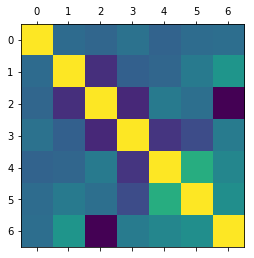

In [14]:
plt.matshow(train.corr())

The heatmap above shows the whiter the square, the more negatively correlated the features are, and vice versa.

Let us also create a scatter matrix for good measure. We're not including Survived and Passenger Id as it is not very helpful

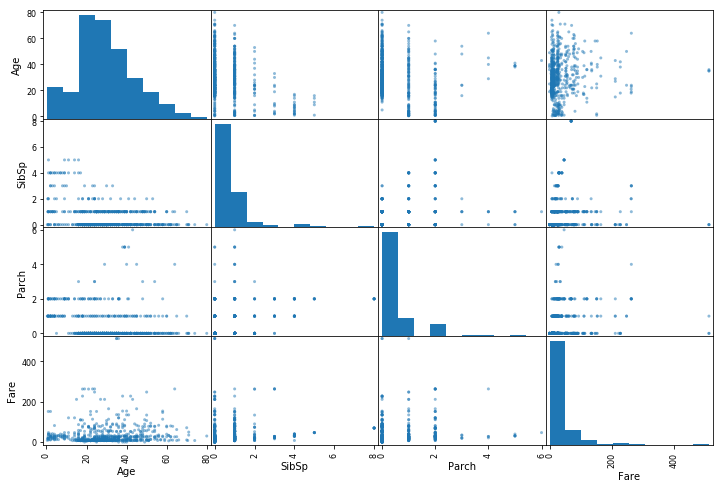

In [15]:
from pandas.plotting import scatter_matrix

attributes = ['Age','SibSp','Parch','Fare']
x = scatter_matrix(train[attributes], figsize=(12,8))

The insights are summarized below: 
* Weak, Positive: Survivability with PClass/Fare (Pclass: -0.3384, Fare: 0.257)
* Weak, Negative: PClass and Age (-0.3692)
* Moderate, Positive: Parch with SibSp (0.414)
* Moderate, Negative: PClass with Fare (-0.550)

**Action Items.**
* Can impute Age with PClass and Fare due to some correlation.
* Feature Engineer: Number of family members, unifying Parch with SibSp

## Initial Hypothesis

With the basic facts above and common intuition, we can start making some initial hypotheses of how we can predict survivability. These hypotheses will give us a better direction of what to explore and validate, focusing on more relevant features and insights.

We can hypothesize that these types of passengers have a higher probability of survivability:
* Women (mothers especially) and children
* Those who are wealthier (PClass, Fare)
* Those with a higher social status (PClass, Fare, Title..?)
* Those who live on upper parts of the boat (Cabin)
* Those with family members (..?)

## Visualize: Hypothesis Validation

Let's now make some visualizations to explore our hypotheses.

**Do more children survive?**

First, let us see if age impacts survivability greatly. From the results below, we can see more infants survived ( (<5 years old).

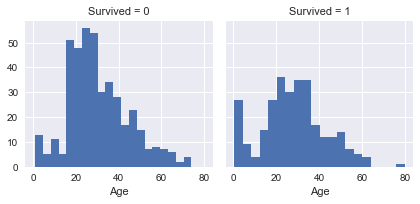

In [16]:
sns.set(style = 'darkgrid')
g = sns.FacetGrid(train, col = 'Survived')
g.map(plt.hist, 'Age', bins=20)

**Do more women survive?**

We can see that females survive more compared to males.

In [17]:
len(train[train['Sex'] == 'male'])

577

In [18]:
print('Percentage of males that survived: ',float(len(train[(train['Sex'] == 'male') & (train['Survived'] == 1)]))/len(train[train['Sex'] == 'male']))
print('Percentage of females that survived: ',float(len(train[(train['Sex'] == 'female') & (train['Survived'] == 1)]))/len(train[train['Sex'] == 'female']))

('Percentage of males that survived: ', 0.18890814558058924)
('Percentage of females that survived: ', 0.7420382165605095)


**Does richer/higher fare people survive?**

There are a few indicators of wealth in this dataset: Title, PClass, and Fare. Let us explore these variables in our visualizations.

**Do mothers survive?**

To determine if mothers survive, we would first need to derive title from the columns. Let us quickly do so.

In [19]:
def create_title(df):
    df['Title'] = [name.split(',')[1].split('.')[0].replace(' ','') for name in train['Name']]

create_title(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Let's look at top-level information about the Title feature.

In [20]:
train['Title'].describe()

count     891
unique     17
top        Mr
freq      517
Name: Title, dtype: object

In [21]:
train['Title'].unique() #unique valuesa

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'theCountess',
       'Jonkheer'], dtype=object)

## EDA Conclusions

Summarized from action items: 
* Drop Ticket feature: too much variation, not much insight can be taken without proper key.
* Drop PassengerId: only acts as counter
* Impute: Embarked, Age, Cabin
* Impute: Can impute Age with PClass and Fare due to some correlation.
* Feature Engineer: Title, can be derived from name.
* Feature Engineer: Deck, can be derived from cabin.
* Feature Engineer: Number of family members, unifying Parch with SibSp

# 4. Prepare and Clean the Data.

Now let us prepare the data for model fitting.

## Preprocess.

Here are the steps we will take in preprocessing the data:
0. Separate data into labels (y) and features (X).
1. Combine X_train and X_test data.
2. Feature Creation.
3. Drop.
4. Imputation.
    - Categorical
    - Numerical
5. Scaling.
    - OneHotEncoding
6. Split to X_train/X_test.


### 0. Extract y labels from train.

Let's separate the data into y_train, X_train, and X_test.

In [56]:
y_train = train['Survived']
X_train = train.drop(['Survived'], axis = 1)
X_test = test

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin #for creating custom classes
from sklearn.pipeline import Pipeline #for creating pipelines
from future_encoders import ColumnTransformer #to combine all pipelines

### 1. Combine.

Then, we combine train and test data so that our imputation, scaling, and encoding is uniform and will not cause any trouble when predicting.

In [58]:
full_df = pd.concat([X_train,X_test])
full_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Feature Creation.

#### 2a. Family.
We create a Family feature, which adds both Parch and SibSp

In [59]:
def create_by_adding_two_features(df, new_feat, first_feat, second_feat):
    
    #add new feature
    df[new_feat] = df[first_feat] + df[second_feat]
    
    return df

#### 2b. Title.

Next, let's reiterate the function to create a title feature from Name.

In [60]:
def create_title(df):
    df['Title'] = [name.split(',')[1].split('.')[0].replace(' ','') for name in df['Name']]

#### 2c. Deck.

Finally, let's create Deck from Cabin name.

In [61]:
import re

def create_deck(df):
    #improve by finding out how to find NaN
    df['Cabin'] = df['Cabin'].fillna('NA')
    deck = list()
    for cabin in df['Cabin']:
        if cabin != 'NA':
            deck.append(re.sub('[0-9]*','',cabin).split(' ')[0])
    else:
        deck.append('NA')
    df['Deck'] = deck
    df = df.drop(['Cabin'], axis = 1)

### 3. Drop.

Next, we drop Name, Ticket, and Passenger_Id as they do not give any additional information.

In [67]:
def drop_features(df, list_col):
    df = df.drop(list_col, axis = 1)
    return df

### 3. Imputation.
#### 3a. Numerical.
We will use sklearn's Imputer for this case and use the median strategy.

In [68]:
from sklearn.preprocessing import Imputer

#Impute numerical columns
def impute_num(df, strategy, columns_to_impute):
    
    imputer = Imputer(strategy = strategy)
    
    for column in columns_to_impute:
        df[[column]] = imputer.fit_transform(df[[column]])
    
    return df

#### 3b. Categorical.

For now, we will use a custom imputer to impute Embarked. **(Could do a better imputer here)**

In [69]:
def impute_embarked(df, column, custom_value):
    
    df[[column]] = df[[column]].fillna(custom_value)
    
    return df

### 4. Scale.

We use sklearn's RobustScaler to scale the data.

In [70]:
from sklearn.preprocessing import RobustScaler

def scale_robust(df, columns_to_scale):
    
    robust = RobustScaler()
    
    for column in columns_to_scale:
        df[[column]] = robust.fit_transform(df[[column]])
        
    return df 

### 5. Encode.

Next, we use pandas.get_dummies to one-hot encode these categorical variables.

In [71]:
def encode_dummies(df, columns_to_encode): 
    return pd.get_dummies(df, prefix = columns_to_encode, columns = columns_to_encode)


### Full Pipeline.

Now let's combine these functions into one full pipeline.

In [77]:
def full_pipeline(X): 
    df = X.copy()
    
    num_cols = ['Age','Fare','Parch','SibSp','Family']
    cat_cols = ['Pclass', 'Sex','Embarked','Title']
    
    #Feature creation
    create_by_adding_two_features(df, 'Family','Parch', 'SibSp')
    create_title(df)
    #create_deck(df) -> future development
    
    #Drop (for now drop cabin)
    df = drop_features(df,['Name','Ticket','PassengerId','Cabin'])
    
    #Impute
    impute_num(df, 'median', num_cols)
    impute_embarked(df, 'Embarked', 'S')
    
    #Scale
    scale_robust(df, num_cols)
    
    #Encode
    df = encode_dummies(df, cat_cols)
    
    return df

Now we can easily preprocess our data with a single function.

In [95]:
X_clean = full_pipeline(full_df)

Then we split the train and test data back to X_train and X_test. 

In [96]:
X_train_clean = X_clean.iloc[list(range(0,len(train)))]
X_test_clean = X_clean.iloc[list(range(len(train),len(X_clean)))]

# 5. Select a Model and Train It. 

Let us now try out different Classification models and test its accuracy by cross-validation. 

In [97]:
#Let's try out a Stochastic Gradient Descent (SaGD)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_clean, y_train)
predicted = sgd_clf.predict(X_test_clean)

** FUTURE WORK: CROSS VALIDATION + TRY OTHER MODELS + DO ENSEMBLING **

Finally, we export the results in the form of csv to submit to the kaggle site. Currently, accuracy of test set is about 74%, which isn't too bad, but not good enough.

In [98]:
passenger_id = np.array(range(892,1310))

pd.DataFrame({'PassengerId':passenger_id, 'Survived':predicted}).to_csv('Prediction.csv')
